In [30]:
import pandas as pd
import csv
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt

def parse_csv(path):
    df = pd.read_csv(path)
    df['Weight'] = df['Weight'].fillna(1)
    df.dropna(axis='rows', how='any', inplace=True)
    return df['Predicate'], df['Weight']

In [13]:
# Open the full CSV
source_folder_path = "C:/Users/Sverre/Documents/UNI/2amd20/2AMD20/data"
compiled_file_source = pd.read_csv(f"{source_folder_path}/preprocessed_data.csv")

In [14]:
compiled_file_source

,Subject,Predicate,Object
0,s-Gravenhage,hasNumberOfDivorced-2021,51572.0
1,s-Gravenhage,hasNumberOfMarried-2021,162437.0
2,s-Gravenhage,hasNumberOfMen-2021,272686.0
3,s-Gravenhage,hasNumberOfPeopleInAgeGroup-0-15-2021,91370.0
4,s-Gravenhage,hasNumberOfPeopleInAgeGroup-15-25-2021,68313.0
...,...,...,...
43803,Werkendam,isPartOf,Noord-Brabant
43804,Winsum,isPartOf,Groningen
43805,Woudrichem,isPartOf,Noord-Brabant
43806,Zederik,isPartOf,Zuid-Holland


In [15]:
# Provide a CSV with the desired predicated for the to be computed ranking
predicates_path = "C:/Users/Sverre/Documents/UNI/2amd20/2AMD20"
file_name = "default_predicates"
input_predicates = pd.read_csv(f"{predicates_path}/{file_name}.csv")

In [16]:
input_predicates

,Predicate,Weight
0,hasNumberOfDivorced-2021,1
1,hasNumberOfMarried-2021,1
2,hasNumberOfMen-2021,1
3,hasNumberOfPeopleInAgeGroup-0-15-2021,1
4,hasNumberOfPeopleInAgeGroup-15-25-2021,1
...,...,...
116,"hasNumberOfMedicalProfessionals-2020,Hospital ...",1
117,"hasNumberOfMedicalProfessionals-2020,Medical D...",1
118,"hasNumberOfMedicalProfessionals-2020,Pharmacist",1
119,"hasNumberOfMedicalProfessionals-2020,Total BIG...",1


In [133]:
# Convert the input CSV to two lists (maintaining the order)
predicates = input_predicates["Predicate"].tolist()
weights = input_predicates["Weight"].tolist()

In [18]:
# Create the function that takes the inputted dataframe of predicates and 
def query_Rankings(predicates, weights):
    # Create a set of lists containing all applicable data to be put in a dataframe later to obtain the rankings
    get_locations_from, count = find_smallest(predicates)
    tmp = compiled_file_source.loc[compiled_file_source["Predicate"] == get_locations_from].copy()
    query_dataframe = tmp["Subject"].to_frame().copy()
    # Now go through all predicates and add the numerical columns
    for predicate in predicates:
        # Set predicate name for column naming
        col_name = predicate
        # Check whether the predicate is numerical, if not, skip
        tmp = compiled_file_source.loc[compiled_file_source["Predicate"] == predicate].copy()
        tmp.rename(columns = {'Object': col_name}, inplace = True)
        if tmp.shape[0] < count: # Temporary failsafe if column is too small
            continue
        cleaned_predicate_df = tmp.drop(["Predicate"], axis=1).copy()
        query_dataframe = query_dataframe.merge(cleaned_predicate_df, how='inner')
        # Now remove any rows containing at least one empty slot (failsafe)
        query_dataframe = query_dataframe[query_dataframe[col_name].notna()]
    # query_dataframe should now contain all >Complete< locations to be ranked
    # meaning each location has a value in all surviving numerical predicates
    # Now, rank all remaining predicates
    for predicate in query_dataframe.columns.values.tolist():
        # Skip "Subject"
        if predicate == "Subject":
            continue
        # Create a new column containing the rank for each predicate and drop the old raw data column
        query_dataframe[predicate] = query_dataframe[predicate].rank()
    # query_dataframe now contains for each subject and all provided (surviving) predicates the ranking amongst each predicate
    # Now, go through the surviving predicates and apply their weights to their ranking
    for predicate in query_dataframe.columns.values.tolist():
        # Skip "Subject"
        if predicate == "Subject":
            continue
        index = predicates.index(predicate)
        weight = weights[index]
        query_dataframe[predicate] = weight * query_dataframe[predicate]
    # Now create a final ranking consisting of the summation of all non-Subject ranks
    query_dataframe["Total_Rank"] = query_dataframe.sum(axis=1, numeric_only=True)
    # Drop the intermediate ranks for the final output
    query_ranked = query_dataframe.copy()
    for col in query_ranked.columns.values.tolist():
        if col == "Subject" or col == "Total_Rank":
            continue
        query_ranked = query_ranked.drop([col], axis=1)
    # Finally, output the subjects based on their final rank order
    query_ranked = query_ranked.sort_values("Total_Rank", ascending=True)
    query_ranked["Rank"] = query_ranked["Total_Rank"].rank()
    return query_dataframe, query_ranked

In [19]:
raw, ranking = query_Rankings(predicates, weights)

<ipython-input-18-cd7b7bf22711>:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  query_dataframe["Total_Rank"] = query_dataframe.sum(axis=1, numeric_only=True)


In [20]:
ranking

,Subject,Total_Rank,Rank
288,Veere,15363.0,1.0
263,Steenbergen,15714.5,2.0
82,Duiven,15794.5,3.0
45,Borsele,16159.5,4.0
51,Brummen,16198.5,5.0
...,...,...,...
197,Nissewaard,23636.5,338.0
114,Hardenberg,23638.0,339.0
8,Almelo,23677.5,340.0
129,Helmond,23846.0,341.0


In [21]:
def find_smallest(predicates):
    smallest = ""
    smallest_count = 10000
    for predicate in predicates:
        count = compiled_file_source.loc[compiled_file_source["Predicate"] == predicate].shape[0]
        if count < smallest_count and not count < 20: #THE COUNT < 20 CHECK IS A FAILSAFE DURING TEST
            smallest = predicate
            smallest_count = count
    return smallest, smallest_count

In [22]:
predicate = "hasNumberOfMen-2021"
rank_column = predicate + "-rank"
tmp = compiled_file_source.loc[compiled_file_source["Predicate"] == predicate].copy()
tmp["Object"] = tmp["Object"].rank()

In [23]:
tmp

,Subject,Predicate,Object
2,s-Gravenhage,hasNumberOfMen-2021,204.0
57,s-Hertogenbosch,hasNumberOfMen-2021,308.0
173,Aa-en-Hunze,hasNumberOfMen-2021,55.0
389,Aalsmeer,hasNumberOfMen-2021,110.0
505,Aalten,hasNumberOfMen-2021,75.0
...,...,...,...
42885,Zundert,hasNumberOfMen-2021,17.0
43001,Zutphen,hasNumberOfMen-2021,183.0
43117,Zwartewaterland,hasNumberOfMen-2021,26.0
43233,Zwijndrecht,hasNumberOfMen-2021,162.0


In [24]:
t = compiled_file_source.loc[compiled_file_source["Predicate"] == predicate].copy()
tmpp = t["Subject"].to_frame().copy()

In [25]:
tmpp

,Subject
2,s-Gravenhage
57,s-Hertogenbosch
173,Aa-en-Hunze
389,Aalsmeer
505,Aalten
...,...
42885,Zundert
43001,Zutphen
43117,Zwartewaterland
43233,Zwijndrecht


In [26]:
tmpp.merge(tmp, how='inner')


,Subject,Predicate,Object
0,s-Gravenhage,hasNumberOfMen-2021,204.0
1,s-Hertogenbosch,hasNumberOfMen-2021,308.0
2,Aa-en-Hunze,hasNumberOfMen-2021,55.0
3,Aalsmeer,hasNumberOfMen-2021,110.0
4,Aalten,hasNumberOfMen-2021,75.0
...,...,...,...
347,Zundert,hasNumberOfMen-2021,17.0
348,Zutphen,hasNumberOfMen-2021,183.0
349,Zwartewaterland,hasNumberOfMen-2021,26.0
350,Zwijndrecht,hasNumberOfMen-2021,162.0


In [27]:
t = compiled_file_source.loc[compiled_file_source["Predicate"] == predicate].copy()
t.rename(columns = {'Object': "test"}, inplace = True)
cleaned = t.drop(["Predicate"], axis=1).copy()

In [28]:
cleaned

,Subject,test
2,s-Gravenhage,272686.0
57,s-Hertogenbosch,76891.0
173,Aa-en-Hunze,12709.0
389,Aalsmeer,15913.0
505,Aalten,13655.0
...,...,...
42885,Zundert,11247.0
43001,Zutphen,23595.0
43117,Zwartewaterland,11598.0
43233,Zwijndrecht,21754.0


In [29]:
cleaned.columns.values.tolist()

['Subject', 'test']

In [134]:
example_relation = ["hasNumberOfDivorced-2021", "hasPopulationDensityPerSquareKm-2021"]

In [136]:
predicates, len(predicates)

(['hasNumberOfDivorced-2021',
  'hasNumberOfMarried-2021',
  'hasNumberOfMen-2021',
  'hasNumberOfPeopleInAgeGroup-0-15-2021',
  'hasNumberOfPeopleInAgeGroup-15-25-2021',
  'hasNumberOfPeopleInAgeGroup-25-45-2021',
  'hasNumberOfPeopleInAgeGroup-45-65-2021',
  'hasNumberOfPeopleInAgeGroup-65-and-older-2021',
  'hasNumberOfUnmarried-2021',
  'hasNumberOfWidowed-2021',
  'hasNumberOfWomen-2021',
  'hasPopulationDensityPerSquareKm-2021',
  'hasPopulationSize-2021',
  'donorRegisterValues-avg-x1000-2019Until2021,inDonorRegister',
  'donorRegisterValues-avg-x1000-2019Until2021,notInDonorRegister',
  'donorRegisterValues-avg-x1000-2019Until2021,total',
  'hasAdmissions-x1000-2019,Men,0-years',
  'hasAdmissions-x1000-2019,Men,1-20-years',
  'hasAdmissions-x1000-2019,Men,20-45-years',
  'hasAdmissions-x1000-2019,Men,45-65-years',
  'hasAdmissions-x1000-2019,Men,65-80-years',
  'hasAdmissions-x1000-2019,Men,80-years-or-older',
  'hasAdmissions-x1000-2019,Women,0-years',
  'hasAdmissions-x1000-2

In [140]:
# Example
p = predicates
p.remove("hasNumberOfDivorced-2021")
p.remove("hasPopulationDensityPerSquareKm-2021")

ValueError: list.remove(x): x not in list

In [138]:
def compute_Relations(relation_predicates, health_predicates, health_weights):
    # Compute the rankings using the provided health predicates and weights
    raw, ranking = query_Rankings(health_predicates, health_weights)
    # Create a subject-only dataframe to add the predicate data to as columns
    relation_data = raw["Subject"].to_frame().copy()
    # For each predicate, merge the data into the dataframe
    for predicate in relation_predicates:
        col_name = predicate
        # Check whether the predicate is numerical, if not, skip
        tmp = compiled_file_source.loc[compiled_file_source["Predicate"] == predicate].copy()
        tmp.rename(columns = {'Object': col_name}, inplace = True)
        cleaned_predicate_df = tmp.drop(["Predicate"], axis=1).copy()
        relation_data = relation_data.merge(cleaned_predicate_df, how='inner')
    # Now loop over each predicate again and plot the relation based on all included subjects in the ranking
    relation_data = relation_data.merge(ranking, how="inner")
    for predicate in relation_predicates:
        relation_data = relation_data.sort_values(predicate, ascending=True)
        plt.figure(figsize=(7, 7), dpi=80)
        plt.scatter(relation_data[predicate], relation_data["Rank"],  alpha=0.5)

<ipython-input-18-cd7b7bf22711>:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  query_dataframe["Total_Rank"] = query_dataframe.sum(axis=1, numeric_only=True)


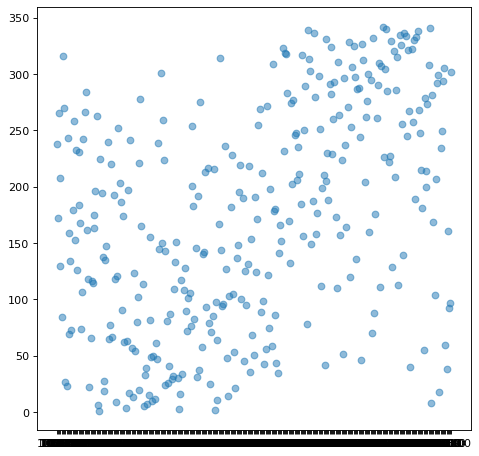

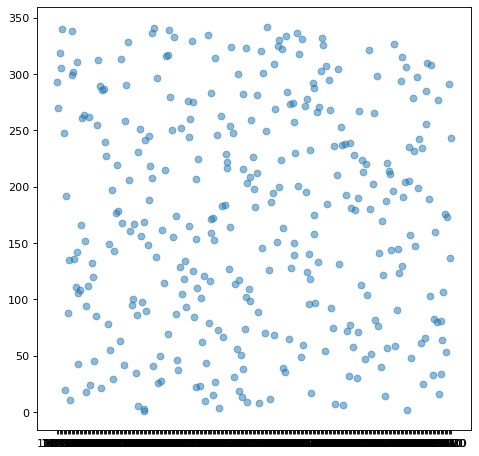

In [139]:
compute_Relations(example_relation, p, weights)